## Import libraries and import data

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from math import ceil

import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,concatenate,Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K

C:\Users\Rahul\Anaconda3\envs\tensorflow_1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
PATH=os.getcwd()
df_depth=pd.read_csv(PATH+'\\data\\depths.csv')
# df_depth_aug=pd.read_csv(PATH+'\\data\\depths_aug.csv')
# df_depth=pd.concat([df_depth,df_depth_aug],axis=0)

df_depth['id']=df_depth['id']+'.png'


## Plan or questions
* threshold optimization based on validation data
* stratification based on area coveres by masks
* try to use seaborn visualizations
* NOTE: If a ground truth is empty and you predict nothing, you get a perfect score for that image. If the ground truth is empty and you predict anything, you get a 0 for that image.
* Ensembling different parts of image or with different neuralnet

In [3]:


## import [training +mask] data and [testing data]
list_depths=[]
avg_int_imgs=[]
train_imgs = []
avg_int_masks=[]
train_masks = []
for img_path in glob(PATH+"\\data\\train\\images\\*"):#+glob(PATH+"\\data\\train\\aug_images\\*")
    
    n= cv2.imread(img_path)
    if np.average(n)!=0:
        n=np.array(n)
        n=cv2.resize(n,(101,101),interpolation = cv2.INTER_CUBIC)
        n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY)
        train_imgs.append(n)
        avg_int_imgs.append(np.average(n))
        
        
        mask_path=img_path.replace('images', 'masks')

        n_mask= cv2.imread(mask_path)
        n_mask=np.array(n_mask)
        n_mask=cv2.resize(n_mask,(101,101),interpolation = cv2.INTER_CUBIC)
        n_mask= cv2.cvtColor(n_mask,cv2.COLOR_BGR2GRAY)
        train_masks.append(n_mask)
        avg_int_masks.append(np.average(n_mask))
        list_depths.append(df_depth[df_depth["id"]==os.path.basename(os.path.normpath(img_path))]['z'].values[0])
        
# list_depths_aug=[]
# # avg_int_imgs_aug=[]
# train_imgs_aug = []
# # avg_int_masks_aug=[]
# train_masks_aug = []

# for img_path in glob(PATH+"\\data\\train\\aug_images\\*"):#+glob(PATH+"\\data\\train\\aug_images\\*")
    
#     n= cv2.imread(img_path)
#     if np.average(n)!=0:
#         n=np.array(n)
#         n=cv2.resize(n,(128,128),interpolation = cv2.INTER_CUBIC)
#         n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY)
#         train_imgs_aug.append(n)
# #         avg_int_imgs.append(np.average(n))
        
        
#         mask_path=img_path.replace('images', 'masks')

#         n_mask= cv2.imread(mask_path)
#         n_mask=np.array(n_mask)
#         n_mask=cv2.resize(n_mask,(128,128),interpolation = cv2.INTER_CUBIC)
#         n_mask= cv2.cvtColor(n_mask,cv2.COLOR_BGR2GRAY)
#         train_masks_aug.append(n_mask)
# #         avg_int_masks.append(np.average(n_mask))
#         list_depths_aug.append(df_depth[df_depth["id"]==os.path.basename(os.path.normpath(img_path))]['z'].values[0])
    
# len(list_depths_aug),len(list_depths)

## visualize images and their masks

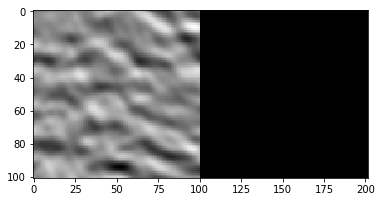

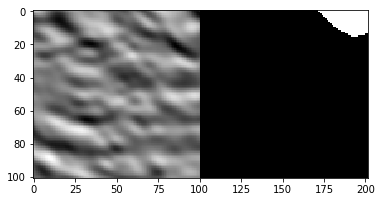

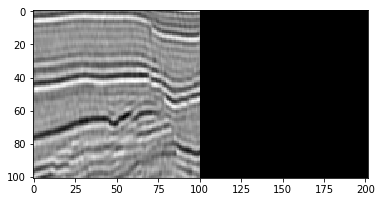

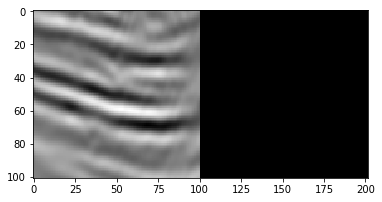

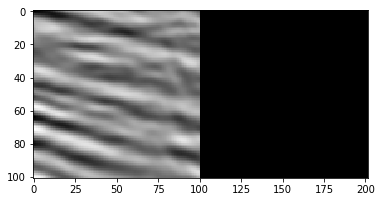

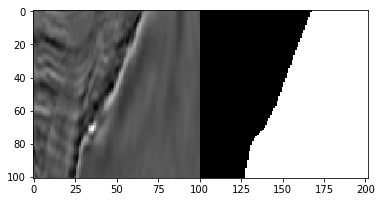

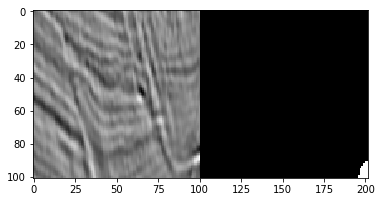

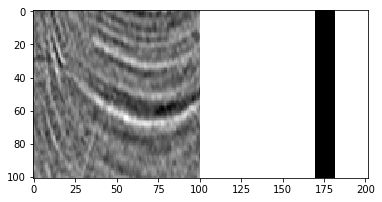

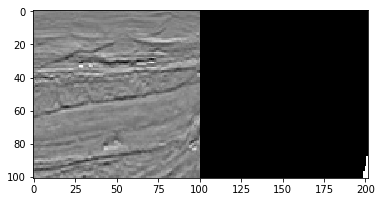

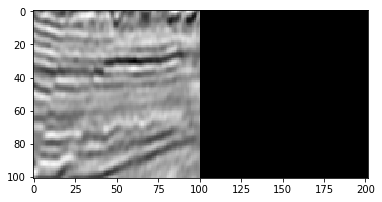

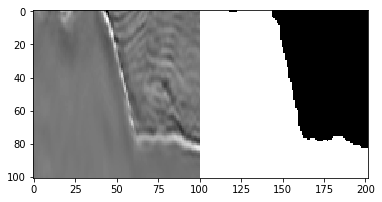

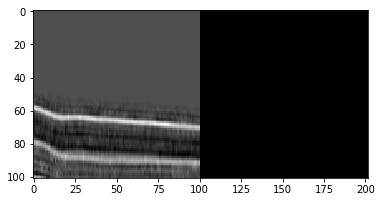

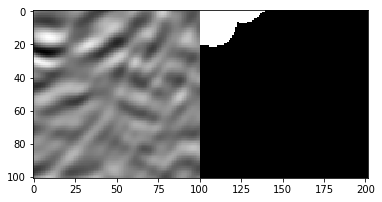

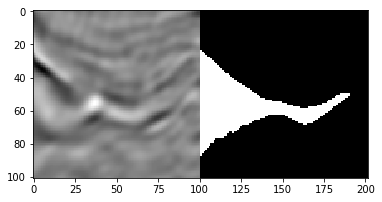

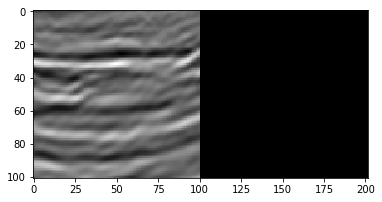

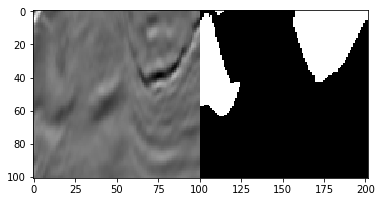

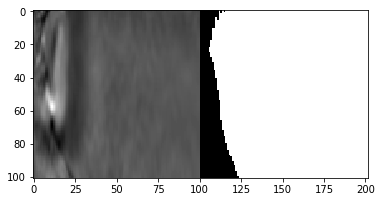

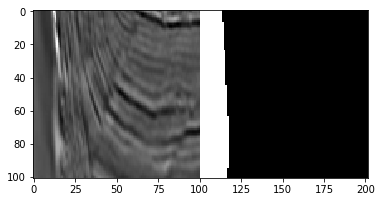

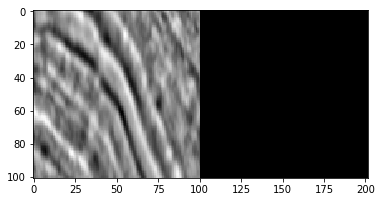

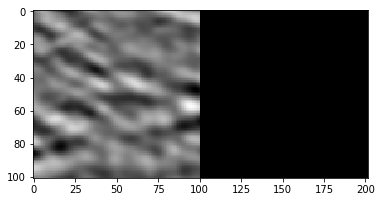

In [4]:
for i in range(20):
    plt.figure()
    plt.imshow(np.concatenate((train_imgs[i], train_masks[i]), axis=1),cmap='gray')

## 5 fold cross validation

In [5]:
ps=np.array([101,101])
cs=np.array([64,64])
ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])


In [6]:



def get_101_img_to_64(np_array):
    ps=np.array([101,101])
    cs=np.array([64,64])
    ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])
       
    
    np_array_1=np_array[:,:cs[0],:cs[0]]
    np_array_2=np_array[:,-cs[0]:,:cs[0]]
    np_array_3=np_array[:,:cs[0],-cs[0]:]
    np_array_4=np_array[:,-cs[0]:,-cs[0]:]
    np_array_mid=np_array[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]

    np_array_all=np.concatenate([np_array_1,np_array_2,np_array_3,np_array_4,np_array_mid],axis=0)

    print("Input shape : ",np_array.shape,"Output shape : ",np_array_all.shape)
    return np_array_all


# X_train.shape,get_101_img_to_64(X_train)

In [59]:
# train test split
df_train=pd.DataFrame()
df_train["imgs"]=train_imgs
df_train["depths"]=list_depths#[[[x]*128]*128 for x in list_depths]

print(set([ceil(x.flatten().sum()/(101.0*101.0*255)*10) for x in train_masks]))


from sklearn.model_selection import train_test_split
df_X_train, df_X_test, y_train, y_test = train_test_split(df_train, train_masks, test_size=0.2, random_state=1234,
                                                          stratify=[ceil(x.flatten().sum()/(101.0*101.0*255)) for x in train_masks])



## Prepare and Add augmentated data to training sample

# df_X_train_aug=pd.DataFrame(columns=['imgs','depths'])
# df_X_train_aug['imgs']=train_imgs_aug
# df_X_train_aug['depths']=list_depths_aug

# df_X_train=pd.concat([df_X_train,df_X_train_aug],axis=0)
# y_train=y_train+train_masks_aug


#normalize data
X_train=np.array(df_X_train['imgs'].values.tolist())
X_test=np.array(df_X_test['imgs'].values.tolist())
X_test_101_org=X_test.copy()
X_train=get_101_img_to_64(X_train)
X_test=get_101_img_to_64(X_test)


X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 64, 64, 1))    # adapt this if using 'channels_first' image data format
X_test = np.reshape(X_test, (len(X_test), 64, 64, 1))


y_train=np.array(y_train)
y_test=np.array(y_test)
y_test_101_org=y_test.copy()
y_train=get_101_img_to_64(y_train)
y_test=get_101_img_to_64(y_test)

y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.
y_train = np.reshape(y_train, (len(y_train), 64, 64, 1))    # adapt this if using 'channels_first' image data format
y_test = np.reshape(y_test, (len(y_test), 64, 64, 1))

df_X_train.shape,df_X_test.shape,len(y_train),len(y_train[0])
# y_train


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Input shape :  (3136, 101, 101) Output shape :  (15680, 64, 64)
Input shape :  (784, 101, 101) Output shape :  (3920, 64, 64)
Input shape :  (3136, 101, 101) Output shape :  (15680, 64, 64)
Input shape :  (784, 101, 101) Output shape :  (3920, 64, 64)


((3136, 2), (784, 2), 15680, 64)

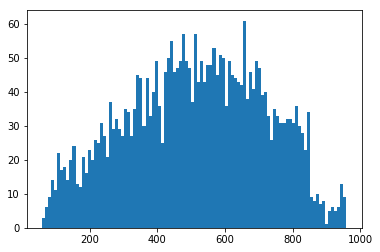

In [8]:
plt.hist(df_X_train["depths"].values, bins=100)
plt.show()

In [9]:
# batch_size = 128
epochs = 50
inChannel = 1
row_len, col_len = 64, 64
input_img = Input(shape = (3200,row_len, col_len, inChannel))
max_depths=max(list_depths)



#define variable input depth metrices
def get_depths_arr(list_depths,row_len,max_depths):
    out=[[[x]*row_len]*row_len for x in list_depths]*5
    out=np.array(out).astype('float32')/float(max_depths)
    out = np.reshape(out, (len(list_depths)*5, row_len, row_len, 1))
    print(out.shape,"123")
    return out

# get_depths_arr(df_X_train['depths'].values.tolist(),23,max_depths)


In [10]:


# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)



In [11]:
input_img = Input(shape=(64,64, 1))    # adapt this if using 'channels_first' image data format

depth_input_8 = Input(shape=(8,8, 1), name='depth_input_8')
depth_input_16 = Input(shape=(16,16, 1), name='depth_input_16')
depth_input_32 = Input(shape=(32,32, 1), name='depth_input_32')
depth_input_64 = Input(shape=(64,64, 1), name='depth_input_64')
# depth_input_128 = Input(shape=(128,128, 1), name='depth_input_128')


conv1_1= Conv2D(8, 3, activation='relu', padding='same')(input_img)
conv1_2= Conv2D(8, 3, activation='relu', padding='same')(conv1_1)
pool_1 = MaxPooling2D((2, 2), padding='same')(conv1_2)
pool_1=Dropout(0.2)(pool_1)

conv2_1= Conv2D(16, 3, activation='relu', padding='same')(pool_1)
conv2_2= Conv2D(16, 3, activation='relu', padding='same')(conv2_1)
pool_2= MaxPooling2D((2, 2), padding='same')(conv2_2)
pool_2=Dropout(0.2)(pool_2)

conv3_1= Conv2D(32, 3, activation='relu', padding='same')(pool_2)
conv3_2= Conv2D(32, 3, activation='relu', padding='same')(conv3_1)
pool_3= MaxPooling2D((2, 2), padding='same')(conv3_2)
pool_3=Dropout(0.2)(pool_3)


conv4_1= Conv2D(32, 3, activation='relu', padding='same')(pool_3)
conv4_2= Conv2D(32, 3, activation='relu', padding='same')(conv4_1)
encoded = MaxPooling2D((2, 2), padding='same')(conv4_2)



# at this point the representation is (4, 4, 8), i.e. 128-dimensional

up4_1 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same') (encoded)
merge_4=concatenate([up4_1, conv4_2,depth_input_8])
# merge_4=Dropout(0.2)(merge_4)
up4_2 = Conv2D(32, 3, activation='relu', padding='same')(merge_4)
up4_3 = Conv2D(32, 3, activation='relu', padding='same')(up4_2)


up3_1 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same') (up4_3)
merge_3=concatenate([up3_1, conv3_2,depth_input_16])
# merge_3=Dropout(0.2)(merge_3)
up3_2 = Conv2D(32, 3, activation='relu', padding='same')(merge_3)
up3_3 = Conv2D(32, 3, activation='relu', padding='same')(up3_2)


up2_1 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same') (up3_3)
merge_2=concatenate([up2_1, conv2_2,depth_input_32])
# merge_2=Dropout(0.2)(merge_2)
up2_2 = Conv2D(16, 3, activation='relu', padding='same')(merge_2)
up2_2 = Conv2D(16, 3, activation='relu', padding='same')(up2_2)



up1_1 = Conv2DTranspose(8, 2, strides=(2, 2), padding='same')(up2_2)
merge_1=concatenate([up1_1, conv1_2,depth_input_64])
# merge_1=Dropout(0.2)(merge_1)
up1_2 = Conv2D(8, 3, activation='relu', padding='same')(merge_1)
up1_3 = Conv2D(8, 3, activation='relu', padding='same')(up1_2)


up0_0 = Conv2D(8, 2, activation='relu', padding='same')(up1_3)
up0_1 = Conv2D(1, 1, activation="sigmoid", padding='same')(up0_0)


autoencoder = Model(inputs=[input_img, depth_input_8,depth_input_16,depth_input_32,depth_input_64], outputs=[up0_1])

autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 8)    584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [ ]:

# # Define IoU metric
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

In [12]:
from keras.models import load_model
# autoencoder.save('autoencode_test.h5')
# autoencoder=load_model('model-tgs-salt-4-1.h5', custom_objects={'mean_iou': mean_iou})

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics=[mean_iou] )


In [13]:
earlystopper = EarlyStopping(patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.001, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt_64-2-1.h5', verbose=1, save_best_only=True)


## define5 fold validation 

In [68]:
autoencoder_train = autoencoder.fit([X_train,
                                     get_depths_arr(df_X_train['depths'].values.tolist(),8,max_depths),
                                     get_depths_arr(df_X_train['depths'].values.tolist(),16,max_depths),
                                     get_depths_arr(df_X_train['depths'].values.tolist(),32,max_depths),
                                     get_depths_arr(df_X_train['depths'].values.tolist(),64,max_depths)],
                                    [y_train], 
                                    batch_size=116,
                                    epochs=100,
                                    verbose=1,
                                    validation_data=(
                                        [X_test,
                                         get_depths_arr(df_X_test['depths'].values.tolist(),8,max_depths),
                                         get_depths_arr(df_X_test['depths'].values.tolist(),16,max_depths),
                                         get_depths_arr(df_X_test['depths'].values.tolist(),32,max_depths),
                                         get_depths_arr(df_X_test['depths'].values.tolist(),64,max_depths)],
                                        [y_test]),
                                    
                                    callbacks=[earlystopper, checkpointer,reduce_lr])

(15680, 8, 8, 1) 123
(15680, 16, 16, 1) 123
(15680, 32, 32, 1) 123
(15680, 64, 64, 1) 123
(3920, 8, 8, 1) 123
(3920, 16, 16, 1) 123
(3920, 32, 32, 1) 123
(3920, 64, 64, 1) 123
Train on 15680 samples, validate on 3920 samples
Epoch 1/100
15680/15680 [==============================] - 24s 2ms/step - loss: 0.1539 - mean_iou: 0.7499 - val_loss: 0.1954 - val_mean_iou: 0.7507

Epoch 00001: val_loss did not improve
Epoch 2/100
15680/15680 [==============================] - 23s 1ms/step - loss: 0.1494 - mean_iou: 0.7516 - val_loss: 0.1832 - val_mean_iou: 0.7524

Epoch 00002: val_loss did not improve
Epoch 3/100
15680/15680 [==============================] - 24s 2ms/step - loss: 0.1448 - mean_iou: 0.7533 - val_loss: 0.1833 - val_mean_iou: 0.7541

Epoch 00003: val_loss did not improve
Epoch 4/100
15680/15680 [==============================] - 24s 2ms/step - loss: 0.1553 - mean_iou: 0.7548 - val_loss: 0.1901 - val_mean_iou: 0.7555

Epoch 00004: val_loss did not improve
Epoch 5/100
15680/15680 [==

# Prepare dividing array

In [40]:
def get_101_dividing_np_array():
    ps=np.array([101,101])
    cs=np.array([64,64])
    ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])
    
    

    child_1=np.zeros(cs)+1
    child_2=np.zeros(cs)+1
    child_3=np.zeros(cs)+1
    child_4=np.zeros(cs)+1
    child_mid=np.zeros(cs)+1
    
    all_child_array=np.zeros((101,101),dtype=float)
    all_child_array[:cs[0],:cs[0]]=all_child_array[:cs[0],:cs[0]]+child_1
    all_child_array[-cs[0]:,:cs[0]]=all_child_array[-cs[0]:,:cs[0]]+child_2
    all_child_array[:cs[0],-cs[0]:]=all_child_array[:cs[0],-cs[0]:]+child_3
    all_child_array[-cs[0]:,-cs[0]:]=all_child_array[-cs[0]:,-cs[0]:]+child_4

    all_child_array[ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=all_child_array[ch_mid_idx[0]:ch_mid_idx[1],
                                                                                             ch_mid_idx[0]:ch_mid_idx[1]]+child_mid
    
    return all_child_array


## prepare for X_test prediction 

In [49]:
pred_imgs_64=autoencoder.predict([X_test,
                              get_depths_arr(df_X_test['depths'].values.tolist(),8,max_depths),
                              get_depths_arr(df_X_test['depths'].values.tolist(),16,max_depths),
                              get_depths_arr(df_X_test['depths'].values.tolist(),32,max_depths),
                              get_depths_arr(df_X_test['depths'].values.tolist(),64,max_depths)],verbose=1)

preds_img_101=np.zeros((int(X_test.shape[0]/5),101,101),dtype=float)
preds_img_101[:,:cs[0],:cs[0]]=preds_img_101[:,:cs[0],:cs[0]]+pred_imgs_64[0:preds_img_101.shape[0],:,:,0]
preds_img_101[:,-cs[0]:,:cs[0]]=preds_img_101[:,-cs[0]:,:cs[0]]+pred_imgs_64[preds_img_101.shape[0]:preds_img_101.shape[0]*2,:,:,0]
preds_img_101[:,:cs[0],-cs[0]:]=preds_img_101[:,:cs[0],-cs[0]:]+pred_imgs_64[preds_img_101.shape[0]*2:preds_img_101.shape[0]*3,:,:,0]
preds_img_101[:,-cs[0]:,-cs[0]:]=preds_img_101[:,-cs[0]:,-cs[0]:]+pred_imgs_64[preds_img_101.shape[0]*3:preds_img_101.shape[0]*4,:,:,0]

preds_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=preds_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]+pred_imgs_64[preds_img_101.shape[0]*4:preds_img_101.shape[0]*5,:,:,0]


preds_img_101_c=preds_img_101/get_101_dividing_np_array()*255.0
# preds_img_101=(preds_img_101>127.5).astype(np.uint8)





(3920, 8, 8, 1) 123
(3920, 16, 16, 1) 123
(3920, 32, 32, 1) 123
(3920, 64, 64, 1) 123
3920/3920 [==============================] - 1s 316us/step


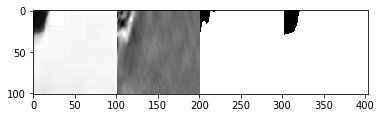

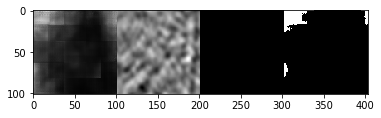

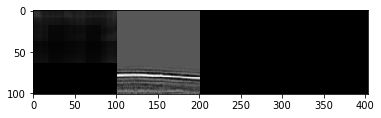

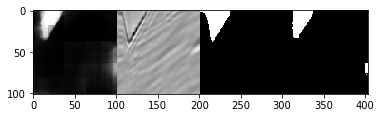

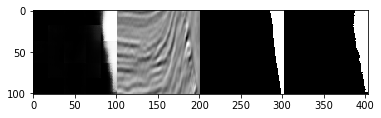

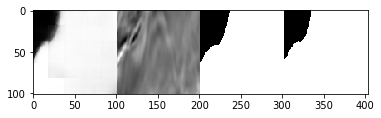

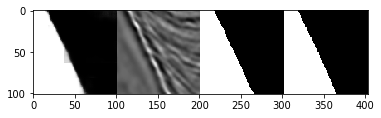

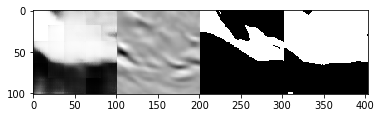

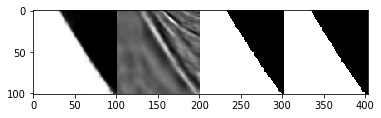

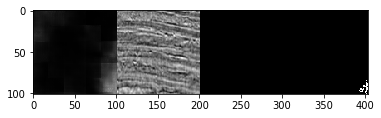

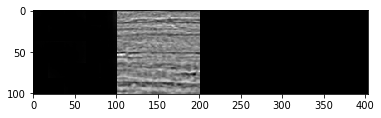

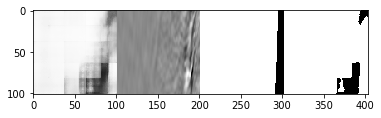

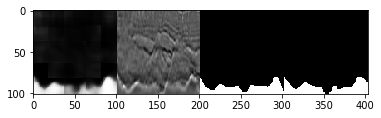

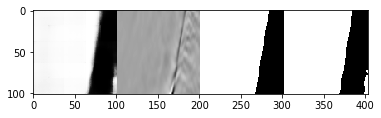

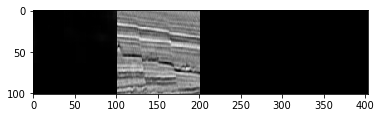

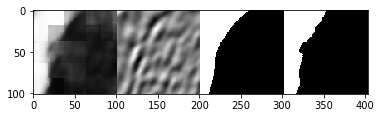

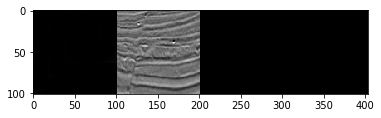

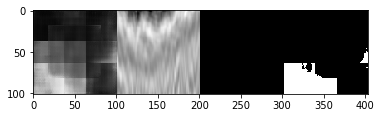

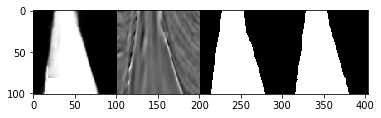

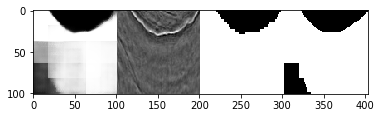

In [67]:
preds_img_101_c#255

for i in range(20):#preds_img_101_c.shape[0]
    img=preds_img_101_c[i]
    plt.figure()
    plt.imshow(np.concatenate((img,X_test_101_org[i],y_test_101_org[i],(img>127.5)*255), axis=1),cmap='gray')
    
    

1/1 [==============================] - 0s 5ms/step


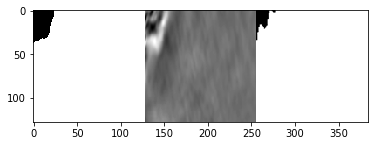

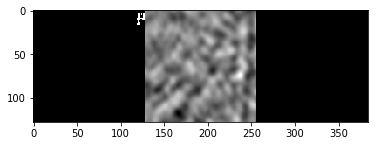

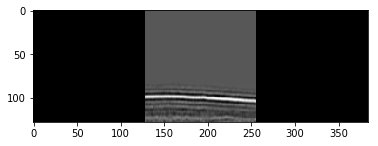

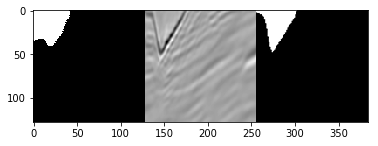

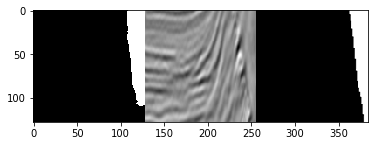

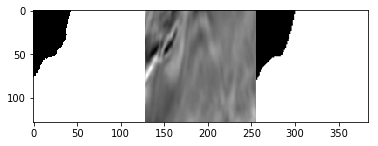

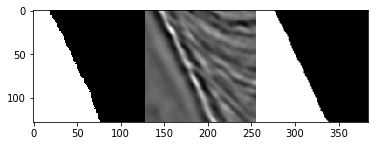

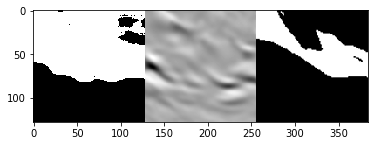

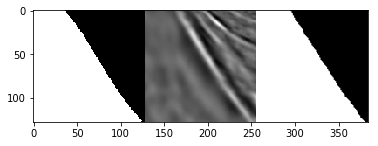

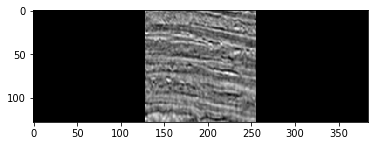

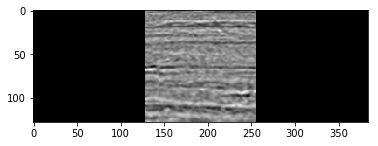

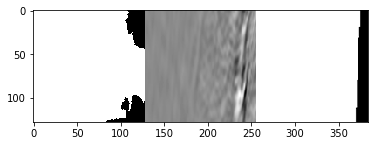

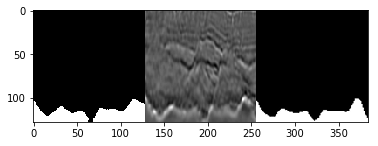

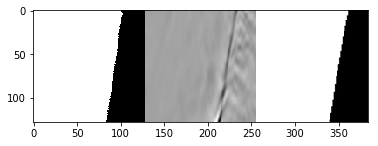

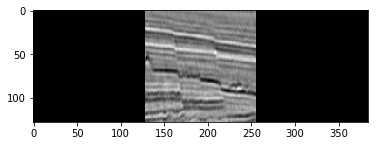

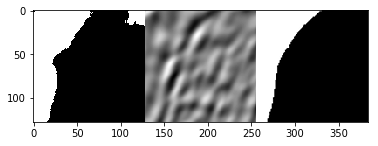

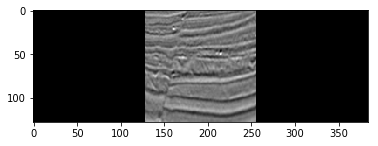

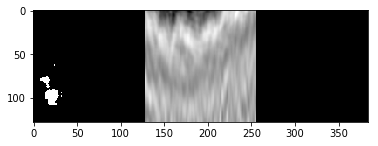

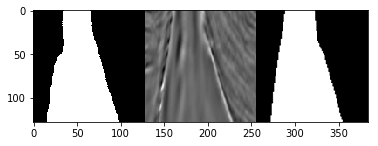

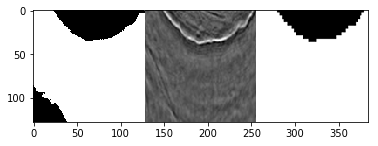

In [74]:
autoencoder=load_model('model-tgs-salt-1-1.h5', custom_objects={'mean_iou': mean_iou})
X_test_depths_extra=get_depths_arr(df_X_test['depths'].values.tolist(),16,max_depths)
for i in range(20):
    pred_img=autoencoder.predict([np.expand_dims(X_test[i], axis=0),
                                  np.expand_dims(get_depths_arr(df_X_test['depths'].values.tolist(),16,max_depths)[i], axis=0),
                                  np.expand_dims(get_depths_arr(df_X_test['depths'].values.tolist(),32,max_depths)[i], axis=0),
                                  np.expand_dims(get_depths_arr(df_X_test['depths'].values.tolist(),64,max_depths)[i], axis=0),
                                  np.expand_dims(get_depths_arr(df_X_test['depths'].values.tolist(),128,max_depths)[i], axis=0)],verbose=1)
    pred_img_t = (pred_img > 0.5).astype(np.uint8)
    plt.figure()
    plt.imshow(np.concatenate((pred_img_t[0,:,:,0]*255,X_test[i,:,:,0]*255,y_test[i,:,:,0]*255), axis=1),cmap="gray")#np.concatenate((test_imgs[i,:,:,0],pred_img[0,:,:,0]), axis=1)


In [69]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs
    
    
    
    
"""
OPTION-2
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



# pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}
# sub = pd.DataFrame.from_dict(pred_dict,orient='index')
# sub.index.names = ['id']
# sub.columns = ['rle_mask']
# sub.to_csv('submission.csv')

# prepare final predictions for submission

In [93]:
# import all images

X_preds=[]
X_preds_img_id=[]
list_X_preds_depths=[]

output_blank_id=[]


for i,img_path in enumerate(glob(PATH+"\\data\\test\\images\\*")):
    img_id=os.path.basename(os.path.normpath(img_path.split(".")[0]))
    n=np.array(cv2.imread(img_path))
    
    if np.average(n)!=0:
        n=cv2.resize(n,(101,101),interpolation = cv2.INTER_CUBIC)
        n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY).astype('float32') / 255.
        n_depth=df_depth[df_depth["id"]==img_id+".png"]['z'].values[0]
        
        X_preds_img_id.append(img_id)
        X_preds.append(n)
        list_X_preds_depths.append(n_depth)
        
    else:
        output_blank_id.append(img_id)

# X_preds Prepareations 
X_preds = np.array(X_preds)
X_preds = get_101_img_to_64(X_preds)
X_preds = np.reshape(X_preds, (len(X_preds), 64, 64, 1))

# import model and then use that mosel to predict images
autoencoder=load_model('model-tgs-salt_64-2-1.h5', custom_objects={'mean_iou': mean_iou})
submi_img_64=autoencoder.predict([X_preds,
                              get_depths_arr(list_X_preds_depths,8,max_depths),
                              get_depths_arr(list_X_preds_depths,16,max_depths),
                              get_depths_arr(list_X_preds_depths,32,max_depths),
                              get_depths_arr(list_X_preds_depths,64,max_depths)],verbose=1)



submi_img_101=np.zeros((int(X_preds.shape[0]/5),101,101),dtype=float)
submi_img_101[:,:cs[0],:cs[0]]=submi_img_101[:,:cs[0],:cs[0]]+submi_imgs_64[0:submi_img_101.shape[0],:,:,0]
submi_img_101[:,-cs[0]:,:cs[0]]=submi_img_101[:,-cs[0]:,:cs[0]]+submi_imgs_64[submi_img_101.shape[0]:submi_img_101.shape[0]*2,:,:,0]
submi_img_101[:,:cs[0],-cs[0]:]=submi_img_101[:,:cs[0],-cs[0]:]+submi_imgs_64[submi_img_101.shape[0]*2:submi_img_101.shape[0]*3,:,:,0]
submi_img_101[:,-cs[0]:,-cs[0]:]=submi_img_101[:,-cs[0]:,-cs[0]:]+submi_imgs_64[submi_img_101.shape[0]*3:submi_img_101.shape[0]*4,:,:,0]

submi_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=submi_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]+submi_imgs_64[submi_img_101.shape[0]*4:submi_img_101.shape[0]*5,:,:,0]


submi_img_101_c=submi_img_101/get_101_dividing_np_array()*255.0
submi_img_101_c=(submi_img_101_c>127.5).astype(np.uint8)

output_X_submi=[RLenc(submi_img_101_c[i], order='F', format=True) for i in range(len(submi_img_101_c))]



Input shape :  (17570, 101, 101) Output shape :  (87850, 64, 64)
(87850, 8, 8, 1) 123
(87850, 16, 16, 1) 123
(87850, 32, 32, 1) 123
(87850, 64, 64, 1) 123
87850/87850 [==============================] - 29s 333us/step


In [95]:
sub = pd.DataFrame()
sub['id']=X_preds_img_id + output_blank_id
sub['rle_mask']=output_X_submi + [np.nan for i in range(len(output_blank_id))]

sub.to_csv('submission1.csv',index=False)
sub

,id,rle_mask
0,0005bb9630,
1,000a68e46c,
2,000c8dfb2a,1 18 25 1
3,000d0a5f6c,24 5 30 5 1112 1 1213 1 1314 1 1415 1 1516 1 1...
4,001ef8fc87,1 7270 7273 91 7374 82 7475 73 7576 64 7677 63...
5,002124aa19,2423 2 2518 8 2615 12 2709 19 2806 23 2902 28 ...
6,002af5d1e8,7882 1 7980 16 8081 21 8182 26 8283 33 8384 38...
7,00323f1910,3 62 78 1 85 2 104 35 143 3 183 1 185 3 204 35...
8,00329dc15c,13 14
9,0041cb8c49,1 1614 1617 96 1718 84 1804 3 1808 1 1819 83 1...


In [68]:
list_test_depths=[]
kernel = np.ones((7,7),np.uint8)
i=0
test_img_id=[]
output_str = []
for i,img in enumerate(glob(PATH+"\\data\\test\\images\\*")):
    test_img_id.append(os.path.basename(os.path.normpath(img.split(".")[0])))
    n= cv2.imread(img)
    n=np.array(n)
    if np.average(n)!=0:
        n=cv2.resize(n,(128,128),interpolation = cv2.INTER_CUBIC)
        n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY).astype('float32') / 255.
        n_depth=df_depth[df_depth["id"]==os.path.basename(os.path.normpath(img))]['z'].values[0]
        list_test_depths.append(n_depth)
        pred_img=autoencoder.predict([n[np.newaxis,:,:,np.newaxis],
                                      get_depths_arr([n_depth],16,max_depths),
                                      get_depths_arr([n_depth],32,max_depths),
                                      get_depths_arr([n_depth],64,max_depths),
                                      get_depths_arr([n_depth],128,max_depths)])

#         pred_img[0,:,:,0] = cv2.morphologyEx(pred_img[0,:,:,0], cv2.MORPH_OPEN, kernel)
#         pred_img[0,:,:,0] = cv2.morphologyEx(pred_img[0,:,:,0], cv2.MORPH_CLOSE, kernel)
        
        pred_img=cv2.resize(pred_img[0,:,:,0],(101,101),interpolation = cv2.INTER_CUBIC)
        output=RLenc((pred_img > 0.5).astype(np.uint8), order='F', format=True)
        output_str.append(output)
        
    else:
        output_str.append("")
        
        
    if i%3000 ==0:
        print(str(i)+" images processed")
    
    
len(output_str),len(test_img_id)

0 images processed
3000 images processed
6000 images processed
9000 images processed
12000 images processed
15000 images processed


(18000, 18000)

In [73]:
print(len(glob(PATH+"\\data\\test\\images\\*")))
sub = pd.DataFrame()
sub['id']=test_img_id
sub['rle_mask']=output_str

sub.to_csv('submission.csv',index=False)
sub

18000


,id,rle_mask
0,0005bb9630,72 30 173 30 274 30 375 30 474 32 575 32 676 3...
1,000a68e46c,
2,000c8dfb2a,1 3917 3922 95 4023 99 4123 93 4217 1 4220 1 4...
3,000d0a5f6c,1 2519 2521 99 2622 98 2724 97 2825 96 2926 96...
4,001ef8fc87,1 1013 1015 99 1116 99 1218 98 1319 98 1420 98...
5,002124aa19,67 35 183 20 299 5 2323 1 2420 5 2517 9 2615 1...
6,002af5d1e8,4157 1 4256 1 7577 3 7677 10 7778 13 7879 19 7...
7,00323f1910,15 21 69 33 117 18 172 31 219 3 223 13 273 31 ...
8,00329dc15c,1 50 66 3 102 49 168 1 203 49 304 50 357 1 360...
9,0035c56490,
